Atmosphere tests on atm code output
=====

To test whether the issue is unique to am, we also investigate whether we see the same issue when using atm.

Note, the following is designed to work in an environment with modular casa loaded via pip. I expect changes would be needed to run this in standalone casa.

First we load the relevant modules.

In [1]:
from casatools import atmosphere as AT
at=AT()
from casatools import quanta as QA
qa=QA()
import matplotlib.pyplot as pl

Then define the function sent by Andrew Lipnicky.

In [ ]:
def atmProfile(freq,pwv,res):
    """
    Purpose:
        Returns a CASA ATM profile object.

    Inputs: 
        freq : 2-element array
            The minimum and maximum frequency of the spectral window that you
            want the ATM profile to cover. In GHz.

        pwv : float
            The PWV you want to impose for the ATM model.

        res : float
            The resolution you want the ATM profile to have in GHz. Note that
            this sets the number of channels, take care to make sure this number
            makes sense. 
    """
    # Setting default values for pressure, humidity, temperature, and airmass.
    airmass = 1.2
    P = 563.0
    H = 20.0
    T = 273.0

    # Setting the atmType to tropical but others are available.
    atmType = 1 #tropical
    
    nchan = int(round((freq[1] - freq[0])/res))

    freqs = np.array(range(nchan+1))*1./(nchan)*(freq[1]-freq[0])+freq[0]
    reffreq=0.5*(freqs[int(nchan/2)-1]+freqs[int(nchan/2)])
    chansep=(freq[1]-freq[0])/(nchan-1)

    fCenter = qa.quantity(reffreq,'GHz')
    fResolution = qa.quantity(chansep,'GHz')
    fWidth = qa.quantity(nchan*chansep,'GHz')

    at.initAtmProfile(
            humidity=H,
            temperature=qa.quantity(T,"K"),
            altitude=qa.quantity(5059,"m"),
            pressure=qa.quantity(P,'mbar'),
            atmType=atmType
            )
    # NB: Andrew's script had atmType=midLatitudeWinter above, which doesn't make sense as it wasn't defined
    # It could mean that further up we should have atmType=3, which would give mid latitude winter
    # However, doing so doesn't have a major effect on the results
    at.initSpectralWindow(1,fCenter,fWidth,fResolution)
    at.setUserWH2O(qa.quantity(pwv,'mm'))

    return at

Set-up the frequency array and PWV (making this consistent with percentile water column used in our other tests.).

In [3]:
freq=[10,2000]
res=0.1
nchan = int(round((freq[1] - freq[0])/res))
freqs = np.array(range(nchan))*1./(nchan)*(freq[1]-freq[0])+freq[0]
pwv = 0.952 # 25%


Then we generate the atmosphere and retrieve the desired variables. I'm assuming the opacity we want is simply the combination of the dry and wet.

In [4]:
atmobj=atmProfile(freq,pwv,res)

tskyz0 = atmobj.getTebbSkySpec()[1]['value']
taudryz0 = atmobj.getDryOpacitySpec()[1]
tauwetz0 = atmobj.getWetOpacitySpec()[1]['value']
# oddly, the ouput of getDryOpacitySpec() is different to that of
# getWetOpacitySpec() in that it's not a dictionary

# I assume we need to combine taudryz0 and tauwetz0
tauz0=taudryz0+tauwetz0
tatm = tskyz0/(1-np.exp(-(tauz0)))

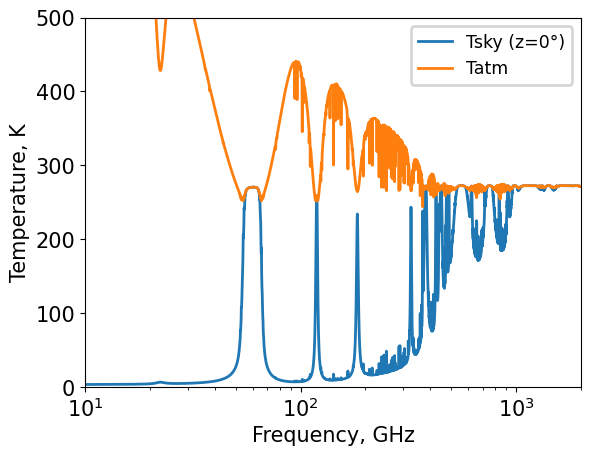

In [5]:
pl.figure()
pl.plot(freqs, tskyz0, label='Tsky (z=0°)')
pl.plot(freqs, tatm, label='Tatm')
pl.xscale('log')
pl.xlim(10,2000)
pl.ylim(0, 500)
pl.xlabel('Frequency, GHz')
pl.ylabel('Temperature, K')
pl.legend(prop={'size':'small'},numpoints=1)